In [87]:
%config IPCompleter.greedy=True
from IPython.display import IFrame

import pandas as pd
import numpy as np
import string
import math

import scipy.stats as sts

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn import preprocessing as prep
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
from sklearn import discriminant_analysis as disan
from sklearn import calibration as calib
from sklearn import linear_model as lm
from sklearn import svm
from sklearn import gaussian_process as gaup
from sklearn import mixture as mix
from sklearn import tree
from sklearn import ensemble as ens

## Helper Functions

#### Helper functions for plotting

In [2]:
def plot_bar_diagram(ax, data, nested=False, plots_labels=None, plots_colors=None, bar_labels='', width=0.4, title='', length_label='',
                     orient='v', legend_loc=None, spines=None):
    """
    Plots single or multiple bar diagrams with data labels on top(aside) of the bars
    :param ax: matplotlib axes
    :param data: pandas DataFrame where rows correspond to bar plots and columns correspond to data labels (columns in data)
    :param nested: boolean. If True, bar plots are plotted on top of each other. If False bar plots are plotted besides each other
    :param bar_labels: pandas DataFrame. labels over the bars. Should be same shape as data
    :param width: float. Bar width
    :param title: string. Plot title
    :param length_label: bar height/width axis label
    :param spines: dictionary of booleans. indicates to plot borders or not. Keys=['left', 'right', 'top', 'bottom'], values=True/False
    :param orient: string. Bar orientation: 'v'-vertical; 'h'-horisontal
    """
    bars = list(data.index)
    cols = list(data.columns)
    cells = data.values.tolist()

    if bar_labels is not None:
        for i, lab in enumerate(bars):
            labels = ([f"{j:.4f}" for j in cells[i]] if bar_labels=='' else bar_labels[i])

    if orient == 'v':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            color = ('r' if plots_colors is None else plots_colors[i])
            x = np.arange(len(cols))
            bar = ax.bar(x=x + width * (i - len(bars) / 2), height=cells[i], width=width,
                         label=label,
                         color=color,
                         align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='v')

        ax.set_xticks(np.arange(len(cols)))
        ax.set_xticklabels(cols)
        if not length_label=='':
            ax.set_ylabel(length_label)
    elif orient == 'h':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            y = np.arange(len(cols))
            height = width
            bar = ax.barh(y=y + height * (i - len(bars) / 2), width=cells[i], height=width,
                          label=label,
                          color=plots_colors[i],
                          align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='h')

        ax.set_yticks(np.arange(len(cols)))
        ax.set_yticklabels(cols)
        if not length_label=='':
            ax.set_xlabel(length_label)
    else:
        raise ValueError('orient parameter value error. expected v or h ')

    if not title == '':
        ttl = ax.title
        ttl.set_position([.5, 1.07])
        ax.set_title(title)
    if legend_loc is not None:
        ax.legend(loc=legend_loc)
    else:
        ax.legend().set_visible(False)

    if spines is None:
        spines = {'left': True,
                  'right': True,
                  'top': True,
                  'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])

def autolabel(bars, ax, labels, oriented='v'):
    """Attach a text label displaying its height/width (depends of orientation)."""
    for bar, label in zip(bars, labels):
        if oriented == 'v':
            height = bar.get_height()
            ax.annotate(label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),
                        textcoords="offset points",
                        ha='center')
        else:
            width = bar.get_width()
            ax.annotate(label,
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(1, 0),
                        textcoords="offset points",
                        ha='left',
                        va='center')

def plot_correlation_matrix(ax, data, cmap='hot', diagonal=False, square=True):
    mask = None
    if diagonal:
        mask = np.zeros_like(data, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax,
                mask=mask,
                square=square,
                linewidths=1.5,
                cmap=cmap,
                cbar_kws={'shrink': 1, 'ticks': [-1, -.5, 0, 0.5, 1]},
                vmin=-1,
                vmax=1,
                annot=True,
                annot_kws={'size': 8})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    
def plot_confusion_matrix(model, X, y, ax, normalize=True, title=None):
    """Plots confusion matrix
    Parameters:
    ax =  matplotlib axes
    normalyze = normalization over truth (number_predicted / total_count_of_this_class)
    """
    model.fit(X,y)
    conf_matrix = metrics.confusion_matrix(y_true=y, y_pred=model.predict(X),
                              labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)
    classes = y.unique()
    classes.sort()
    n_classes = [len(y[y == c]) for c in classes]
    if normalize == True:
        n_matrix = [[i for j in range(len(n_classes))] for i in n_classes]
        norm_matrix = conf_matrix / np.array(n_classes)
        ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
        labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                               ns_matrix[i, j]) for j, v in
                            enumerate(norm_matrix[i])]
                           for i, v in enumerate(norm_matrix)])

        sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues')
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

    ax.set_ylabel('True Labels')
    ax.set_xlabel('Predicted Labels')
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title)
    ttl = ax.title
    ttl.set_position([.5, 1.07])

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = ax.get_ylim()  # discover the values for bottom and top
    b += 0.5  # Add 0.5 to the bottom
    t -= 0.5  # Subtract 0.5 from the top
    ax.set_ylim(b, t)  # update the ylim(bottom, top) values

#### Helper functions for model training

In [3]:
# Tune parameters
def param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=''):
    if refit == '': refit = list(scoring.keys())[0]
    gsearch = model_selection.GridSearchCV(estimator=model, param_grid=param_ranges, scoring=scoring, cv=cv, refit=refit, return_train_score=True,
                           n_jobs=-1)
    gsearch.fit(X_train, y_train)
    cv_res = pd.DataFrame(gsearch.cv_results_)
    cv_res_sel = []
    for i in list(scoring.keys()):
        df = cv_res.loc[cv_res['rank_test_%s' % i] == 1].head(1)
        cv_res_sel.append(df[['mean_train_%s' % i, 'std_train_%s' % i, 'mean_test_%s' % i, 'std_test_%s' % i]].values[0])

    cv_res_sel = pd.DataFrame(cv_res_sel, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_res_sel.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return gsearch.best_estimator_, gsearch.best_params_, gsearch.best_score_, cv_results

# Cross-validation report
def cv_rep(model, X, y, cv, scoring):
    cv_res = model_selection.cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=True, n_jobs=-1)
    cv_res = [[np.mean(cv_res['train_%s' % i]), np.std(cv_res['train_%s' % i]), np.mean(cv_res['test_%s' % i]), np.std(cv_res['test_%s' % i])] for i in list(scoring.keys())]
    cv_results = pd.DataFrame(cv_res, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_results.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return cv_results

# Tune model parameters and print CV report
def train_best_model(model, param_ranges, X_train, y_train, scoring, cv, refit):
    model, best_params, best_score, cv_res = param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

# Tune model parameters and print CV report for calibrated classifier model
def train_best_model_cal(model, param_ranges, X_train, y_train, scoring, cv, refit):
    if model.__class__.__name__=='CalibratedClassifierCV':
         model_cal= model 
    else:
        model_cal = calib.CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv=cv)
    model_cal, best_params, best_score, cv_res = param_tune(model_cal, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

### Import data

## Exploratory Data Analysis

In [4]:
#import train dataset
data_train = pd.read_csv('/kaggle/input/titanic/train.csv')

#import test dataset
data_test = pd.read_csv('/kaggle/input/titanic/test.csv')

### Training Set

In [5]:
data_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Test Set

In [6]:
data_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Checking missing values in training set

In [7]:
nulls = data_train.isnull().sum()
nulls = nulls.loc[nulls > 0]
nulls = nulls.to_frame(name='count')
N = len(data_train.index)
nulls.insert(1, 'percent', ['{0:.2%}'.format(nulls.loc['Age'][0] / N), 
                            '{0:.2%}'.format(nulls.loc['Cabin'][0] / N),
                            '{0:.2%}'.format(nulls.loc['Embarked'][0] / N)])
nulls

,count,percent
Age,177,19.87%
Cabin,687,77.10%
Embarked,2,0.22%


Seems to be a lot of missing values in 'Age' and 'Cabin'.

### Checking missing values in test set

In [8]:
nulls = data_test.isnull().sum()
nulls = nulls.loc[nulls > 0]
nulls = nulls.to_frame(name='count')
nulls

,count
Age,86
Fare,1
Cabin,327


In [219]:
data = data_train[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].copy()

#numerical data
data_num = data[['Age', 'Fare']]

#categorical data
data_cat = data[['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch']]

### Calculate survival rate

In [10]:
#how many died
N_surv0 = len(data_train.loc[data_train['Survived']==0])
#how many survived
N_surv1 = len(data_train.loc[data_train['Survived']==1])

print('Deads: {0} ({1:.2%})'.format(N_surv0, N_surv0 / N))
print('Survivals: {0} ({1:.2%})'.format(N_surv1, N_surv1 / N))

Deads: 549 (61.62%)
Survivals: 342 (38.38%)


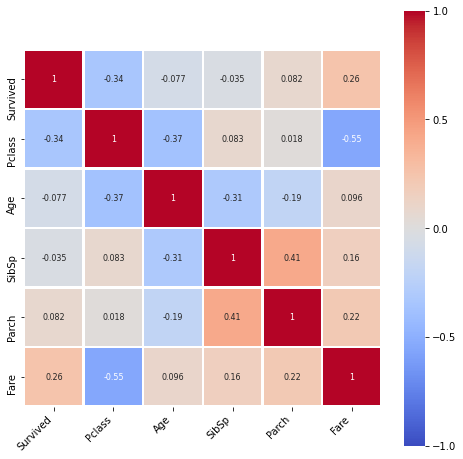

In [11]:
#plot correlation matrix
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap='coolwarm')

In [221]:
grd = list(data_cat.columns)
grd_n = len(grd)
grd_cols_n = 3
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 4

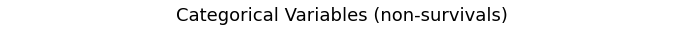

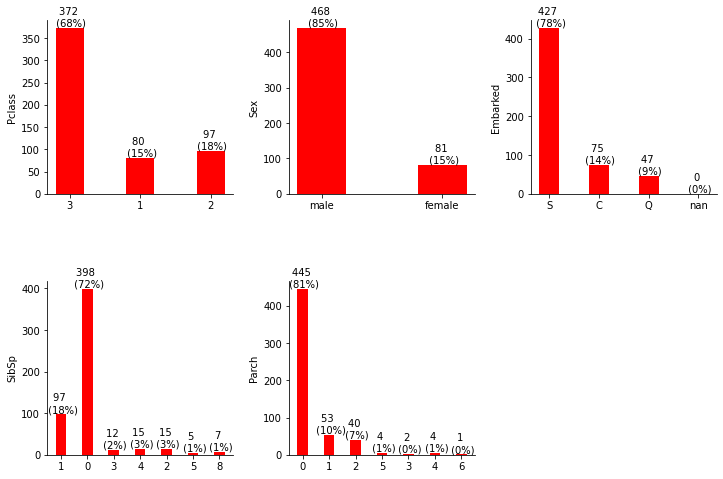

In [222]:
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (non-survivals)', fontsize=18, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in data_cat[col].unique():
        n0 = len(data.loc[(data['Survived']==0) & (data[col]==i), col].index)
        fr0 = n0 / N_surv0
        freq.append([n0])
        frc.append([fr0])

    df_freq = pd.DataFrame(freq, columns=['non_survivals'], index=data_cat[col].unique()).T
    df_frc = pd.DataFrame(frc, columns=['non_survivals'], index=data_cat[col].unique()).T
    labs0 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['non_survivals'], df_frc.loc['non_survivals'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs0],
                           plots_labels=None,
                           plots_colors=['r'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})

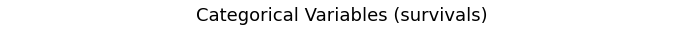

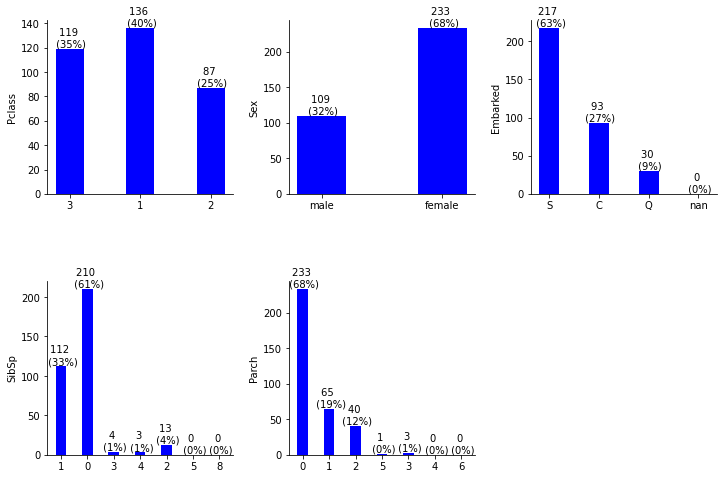

In [223]:
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (survivals)', fontsize=18, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in data_cat[col].unique():
        n1 = len(data.loc[(data['Survived']==1) & (data[col]==i), col].index)
        fr1 = n1 / N_surv1
        freq.append([n1])
        frc.append([fr1])

    df_freq = pd.DataFrame(freq, columns=['survivals'], index=data_cat[col].unique()).T
    df_frc = pd.DataFrame(frc, columns=['survivals'], index=data_cat[col].unique()).T
    labs1 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['survivals'], df_frc.loc['survivals'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs1],
                           plots_labels=None,
                           plots_colors=['b'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})

In [15]:
grd = list(data_num.columns)
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 3
plt_w = 6

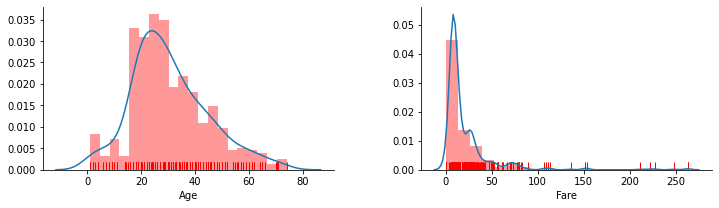

In [16]:
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (NON-SURVIVALS)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data.loc[data['Survived']==0, col].dropna()
    ax = sns.distplot(df,
                 bins=20, kde=True, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "r"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ttl = ax.title
    ttl.set_position([.5, 1.07])

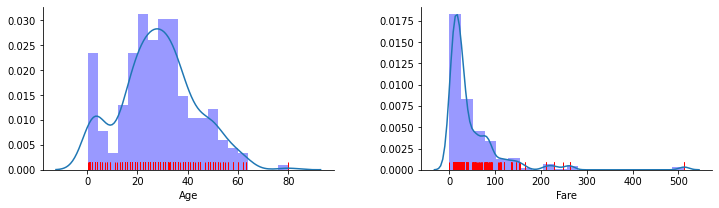

In [17]:
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (SURVIVALS)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data.loc[data['Survived']==1, col].dropna()
    ax = sns.distplot(df,
                 bins=20, kde=True, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ttl = ax.title
    ttl.set_position([.5, 1.07])

**Preliminary Conclusions**
* The Pclass and Sex features have significantly different distributions for survivals and non-survivals.
* The Age distribution for survivals has a noticeable peak between 0 and 10 that means increased survival probability for children of this age.

## Feature Engineering

In this section I will do a certain transformations to existing features to make them more 'useful' for model. I will also derive some new features that will potentially increase model performance.

In [18]:
# Concatinate train & test data
data_tot = pd.concat([data_train, data_test], ignore_index=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


### Replace 'Name' with encoded titles

In this section I split passenger name to derive last name and title. Then I define the most frequent titles and encode them.

In [19]:
#Encode 'Name'
def name_encoder(data):
    data_encoded = []
    for i in data['Name']:
        lname0 = i.split(',')[0].strip() #last name
        ttl = i.split(',')[1].split('.')[0].strip() #title
        lname1 = (i.split('(')[-1].split(')')[0].split()[-1].strip() if '(' in i else '').replace('\"','') #second last name
        data_encoded.append([lname0, lname1, ttl])
    data_encoded = pd.DataFrame(data_encoded, columns=['lname0', 'lname1', 'ttl'], index=data.index)
    return pd.concat([data.reset_index(drop=True), data_encoded], axis=1)

In [20]:
df_name = name_encoder(data_tot['Name'].to_frame())
df_name.head(5)

,Name,lname0,lname1,ttl
0,"Braund, Mr. Owen Harris",Braund,,Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Cumings,Thayer,Mrs
2,"Heikkinen, Miss. Laina",Heikkinen,,Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Futrelle,Peel,Mrs
4,"Allen, Mr. William Henry",Allen,,Mr


In [21]:
#Find unique titles and their counts
ttl = df_name['ttl'].unique()
ttl = pd.DataFrame([[i, len(df_name.loc[df_name['ttl']==i])] for i in ttl], columns=['ttl', 'ttl_n'])
ttl.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
ttl,Mr,Mrs,Miss,Master,Don,Rev,Dr,Mme,Ms,Major,Lady,Sir,Mlle,Col,Capt,the Countess,Jonkheer,Dona
ttl_n,757,197,260,61,1,8,8,1,2,2,1,1,2,4,1,1,1,1


The most frequent titles are 'Mr', 'Mrs', 'Miss' and 'Master'. Other titles frequencies are too low and can be neglected.

In [22]:
#Explore samples with 'Dr' title
df_name.loc[df_name['ttl']=='Dr']

,Name,lname0,lname1,ttl
245,"Minahan, Dr. William Edward",Minahan,,Dr
317,"Moraweck, Dr. Ernest",Moraweck,,Dr
398,"Pain, Dr. Alfred",Pain,,Dr
632,"Stahelin-Maeglin, Dr. Max",Stahelin-Maeglin,,Dr
660,"Frauenthal, Dr. Henry William",Frauenthal,,Dr
766,"Brewe, Dr. Arthur Jackson",Brewe,,Dr
796,"Leader, Dr. Alice (Farnham)",Leader,Farnham,Dr
1184,"Dodge, Dr. Washington",Dodge,,Dr


_**Leader, Dr. Alice (Farnham) is only one woman with title 'Dr'._

The function below will replace each person's name with encoded title. Instead of using all unique titles, I will teke only these: 'Mr', 'Mrs', 'Miss' and 'Master'.

In [23]:
def title_encoder(data):
    mask = {'Don':'Mr',
            'Sir':'Mr',
            'Jonkheer':'Mr',
            'Mme':'Mrs',
            'Lady':'Mrs',
            'the Countess':'Mrs',
            'Dona':'Mrs',
            'Mlle':'Miss',
            'Ms':'Miss',
            'Major':'Mr',
            'Col':'Mr',
            'Capt':'Mr',
            'Rev':'Mr',
            'Dr':'Mr'}
    
    data = name_encoder(data)
    data['ttl'] = data['ttl'].apply(lambda i: mask[i] if i in mask else i)
    if 797 in data['PassengerId'].values:
        data.loc[data_tot['PassengerId']==797, 'ttl'] = 'Mrs'
    mask = {'Mr':1, 'Mrs':2, 'Miss':3, 'Master':4}
    data['ttl'] = data['ttl'].apply(lambda i: mask[i])
    return data

### Explore missing values for 'Embarked'

In [24]:
data_tot.loc[data_tot['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


Display samples with similar ticket number

In [25]:
df = data_tot.loc[data_tot['Ticket'].str.contains('1135')]
df.sort_values(by='Ticket')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
782,29.0,D6,S,30.0000,"Long, Mr. Milton Clyde",0,783,1,male,0,0.0,113501
377,27.0,C82,C,211.5000,"Widener, Mr. Harry Elkins",2,378,1,male,0,0.0,113503
965,35.0,C130,C,211.5000,"Geiger, Miss. Amalie",0,966,1,female,0,NaN,113503
966,32.5,C132,C,211.5000,"Keeping, Mr. Edwin",0,967,1,male,0,NaN,113503
1109,50.0,C80,C,211.5000,"Widener, Mrs. George Dunton (Eleanor Elkins)",1,1110,1,female,1,NaN,113503
1298,50.0,C80,C,211.5000,"Widener, Mr. George Dunton",1,1299,1,male,1,NaN,113503
166,NaN,E33,S,55.0000,"Chibnall, Mrs. (Edith Martha Bowerman)",1,167,1,female,0,1.0,113505
356,22.0,E33,S,55.0000,"Bowerman, Miss. Elsie Edith",1,357,1,female,0,1.0,113505
54,65.0,B30,C,61.9792,"Ostby, Mr. Engelhart Cornelius",1,55,1,male,0,0.0,113509
917,22.0,B36,C,61.9792,"Ostby, Miss. Helene Ragnhild",1,918,1,female,0,NaN,113509


*All people with similar ticket numbers are embarked in 'C' or 'S'. So i will simply assign the most frequent class to both missed values.*

In [26]:
nc = len(df.loc[df['Embarked']=='C'])
ns = len(df.loc[df['Embarked']=='S'])
n = len(df.index)

print('C: %d' % nc)
print('S: %d' % ns)
print('All: %d' % n)

C: 7
S: 5
All: 14


The function below will be used to encode 'Embarked' variable

In [27]:
#Encoding 'Embarked'
def embarked_encoder(data):
    if len(data.loc[data['Embarked'].isnull()].index)>0:
        data = data.fillna(value={'Embarked':'C'})
    mask = {'C':0, 'S':1, 'Q':2}
    data['Embarked'] = data['Embarked'].apply(lambda i: mask[i])
    return data

### Grouping by ticket ID

While exploring the dataset, I found that many passengers have identical ticket numbers as well as identical fare value.

I will recalculate ticket fare for every i-th person in a group g of matching tickets as: fare(i, g) = fare(g) / n, where n is a number of people in group g.

Note that in some cases, passengers have same ticket ID but different fare values. The fare recalculation is not performed for such a cases.

For cases where fare value is 0, I assign it a mean of corresponding Pclass.


In [28]:
# Clean text function
def clean_text(text):
    text = ''.join([c for c in text if c not in string.punctuation]).strip()
    text = ''.join(text.split())
    return text

In [29]:
# Clean ticket ID from all punctuation and spaces
df_fam = data_tot.copy()
df_fam['Ticket'] = df_fam['Ticket'].apply(lambda i: clean_text(i))

Numbers of unique and non-unique tickets:

In [30]:
print('Unique tickets: %d' % len(df_fam['Ticket'].unique()))
print('Non-unique tickets: %d' % (len(df_fam.index) - len(df_fam['Ticket'].unique())))

Unique tickets: 929
Non-unique tickets: 380


I want to define the following groups:
1. No family (SibSp==0 & Parch==0), unique tickets
2. No family (SibSp==0 & Parch==0), non-unique tickets
3. Has family, no children (SibSp >0 & Parch==0), unique tickets
4. Has family, no children (SibSp >0 & Parch==0), non-unique tickets
5. Has family, has children (Parch >0), unique tickets
6. Has family, has children (Parch >0), non-unique tickets

In [31]:
families0 = df_fam.loc[(df_fam['SibSp']>0) & (df_fam['Parch']==0)]
families1 = df_fam.loc[df_fam['Parch']>0]
singles = df_fam.loc[(df_fam['SibSp']==0) & (df_fam['Parch']==0)]

In [32]:
# This function is used to return sub-groups by unique and non-unique tickets from a group by SibSP and Parch
def grps_by_size(grp):
    #group size > 1
    grp1 = None
    #group size == 1
    grp0 = None
    for g in grp.groups:
        grp_ = grp.get_group(g)
        if len(grp.get_group(g).index)>1:
            if grp1 is None:
                grp1 = grp_
            else:
                grp1 = pd.concat([grp1, grp_])
        else:
            if grp0 is None:
                grp0 = grp_
            else:
                grp0 = pd.concat([grp0, grp_])
    return (grp0, grp1)

In [33]:
#singles
sig_grp = singles.groupby('Ticket')
#families NO children
fam0_grp = families0.groupby('Ticket')
#families w/children
fam1_grp = families1.groupby('Ticket')

#no family, unique ticket
sig0 = grps_by_size(sig_grp)[0]
#no family, matching tickets
sig1 = grps_by_size(sig_grp)[1]
#has family, no children, unique ticket
fam0 = grps_by_size(fam0_grp)[0]
#has family, no children, matching ticket
fam1 = grps_by_size(fam0_grp)[1]
#has family, has children, unique ticket
famch0 = grps_by_size(fam1_grp)[0]
#has family, has children, matching ticket
famch1 = grps_by_size(fam1_grp)[1]

print('Singles-----------------------')
print('Matching tickets groups: %d' % len(sig1.index))
print('Unique tickets groups: %d' % len(sig0.index))
print('------------------------------')

print('Families----------------------')
print('Matching tickets groups: %d' % len(fam1.index))
print('Unique tickets groups: %d' % len(fam0.index))
print('------------------------------')

print('Families W/children-----------')
print('Matching tickets groups: %d' % len(famch1.index))
print('Unique tickets groups: %d' % len(famch0.index))
print('------------------------------')

Singles-----------------------
Matching tickets groups: 108
Unique tickets groups: 682
------------------------------
Families----------------------
Matching tickets groups: 174
Unique tickets groups: 38
------------------------------
Families W/children-----------
Matching tickets groups: 288
Unique tickets groups: 19
------------------------------


In [34]:
# Family groups
fam_grps = [sig0, sig1, fam0, fam1, famch0, famch1]

In [35]:
# Make a mask of family groups labels
fgrp_mask = {}
for idx, grp in enumerate(fam_grps):
    for pid in grp['PassengerId']:
        fgrp_mask[pid] = idx

In [50]:
# Make a mask of ticket fare
df_fam = df_fam.fillna(value={'Fare':0})
fare_mask = {}
for tic in df_fam['Ticket'].unique():
    # subgroup with matching tickets
    tic_grp = df_fam.loc[df_fam['Ticket']==tic]
    
    # passenger class that the subgroup belongs to
    c = tic_grp['Pclass'].values[0]
    
    # ticket fare of the subgroup
    # all subgroup members have the same ticket fare initially
    fare_grp = tic_grp['Fare'].values[0]
    
    # if a subgroup fare is 0 then assign a mean of the fare of the Pclass that the subgroup belongs to
    if fare_grp == 0:
        fare_i = np.mean(df_fam.loc[df_fam['Pclass']==c, 'Fare'])
        for pid in tic_grp['PassengerId']:
            fare_mask[pid] = fare_i

    # recalculate fare for subrgoup members: fare_i = group_fare / n_members
    if len(tic_grp.index) > 1:
        if fare_grp > 0:
            
            if np.mean(tic_grp['Fare'])==fare_grp: #check if all group members have same fare
                fare_i = fare_grp / len(tic_grp.index)
                for pid in tic_grp['PassengerId']:
                    fare_mask[pid] = fare_i
            else:
                for pid in tic_grp['PassengerId']:
                    fare_mask[pid] = tic_grp.loc[tic_grp['PassengerId']==pid, 'Fare'].values[0]
    # keep fare value for passengers with unuque tickets
    else:
        if fare_grp > 0:
            fare_i = fare_grp
            for pid in tic_grp['PassengerId']:
                fare_mask[pid] = fare_i

In [101]:
# Make a mask of ticket codes
# For ticket IDs that belongs to multiple passengers, set 1 othervise set 0
m_tickets = []
for tic in df_fam['Ticket'].unique():
    if len(df_fam.loc[df_fam['Ticket']==tic].index) > 1:
        m_tickets.append(tic)

ticket_mask = {}        
for pid in df_fam['PassengerId']:
    tic = df_fam.loc[df_fam['PassengerId']==pid, 'Ticket'].values[0]
    if tic in m_tickets:
        ticket_mask[pid] = 1
    else:
        ticket_mask[pid] = 0

In [102]:
# Encode family groups
# This function adds new class variable 'fgrp' that indicates a group that a passenger belongs to.
def family_groups_encoder(data, fgrp_mask):
    # assign a label
    data['fgrp'] = data['PassengerId'].apply(lambda i: fgrp_mask[i])
    # replace labels with corresponding counts
    data['fgrp'] = data['fgrp'].apply(lambda i: len(data.loc[data['fgrp']==i].index))
    return data

# Recalculate ticket fare in the family groups and fill missing values with a mean for corresponding passenger class and then log-transform.
def fare_encoder(data, fare_mask):
    data['Fare'] = data['PassengerId'].apply(lambda i: fare_mask[i])
    data['Fare'] = data['Fare'].apply(np.log)
    return data

# Encode tickets
def ticket_encoder(data, ticket_mask):
    data['Ticket'] = data['PassengerId'].apply(lambda i: ticket_mask[i])
    return data

### Other variables encoding

In [103]:
# Encode 'Sex'
def sex_encoder(data):
    mask = {'male':0, 'female':1}
    data['Sex'] = data['Sex'].apply(lambda i: mask[i])
    return data

# Add family size
def fam_size(data):
    data['famsize'] = data['SibSp'] + data['Parch']
    return data

#Encoding 'Pclass' (to labels 0,1,2)
def pclass_encoder(data):
    data['Pclass'] = data['Pclass'].apply(lambda i: i-1)
    return data

### Age prediction

I want to use 2-step approach to predict missing values for Age.

1. Use BayesianGaussianMixture to define clusters in the existing Age data and then train a classifier that will predict these cluster labels based on other features.
2. Train a regression model that will predict Age values based on existing features and Age class labels.

In [66]:
# Log-transform 'Age'
df_age = data_tot['Age'].dropna().copy().to_frame()
df_age['Age_trans'] = df_age['Age'].apply(np.log)

In [67]:
#Define clustering model
age_clast_model = mix.BayesianGaussianMixture(n_components=3, 
                                              covariance_type='spherical', 
                                              init_params='kmeans', 
                                              weight_concentration_prior_type='dirichlet_distribution', 
                                              max_iter=1000,
                                              random_state=30)

In [68]:
#Predict cluster labels
X = df_age['Age_trans'].to_frame()
df_age['Age_cls'] = age_clast_model.fit_predict(X)
df_age['Age_cls'] = df_age['Age_cls'].astype(int)

### Predicted clusters

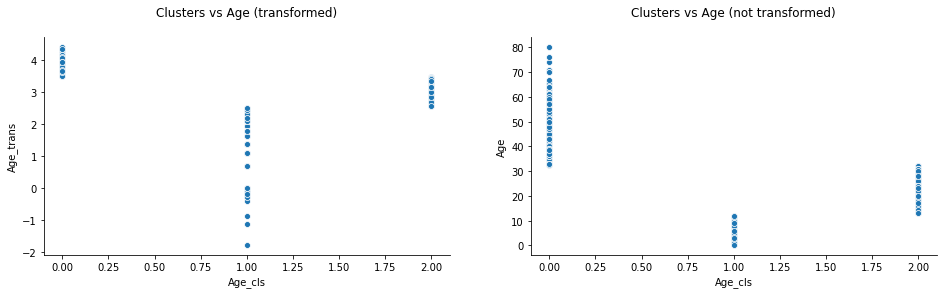

In [69]:
fig = plt.figure()
fig.set_size_inches(16,4)

fig.add_subplot(1,2,1)
ax = sns.scatterplot(x='Age_cls', y='Age_trans', data=df_age)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ttl = ax.title
ttl.set_position([.5, 1.07])
a=ax.set_title('Clusters vs Age (transformed)')

fig.add_subplot(1,2,2)
ax = sns.scatterplot(x='Age_cls', y='Age', data=df_age)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ttl = ax.title
ttl.set_position([.5, 1.07])
a=ax.set_title('Clusters vs Age (not transformed)')

### Distributions within clasters (age - transformed)

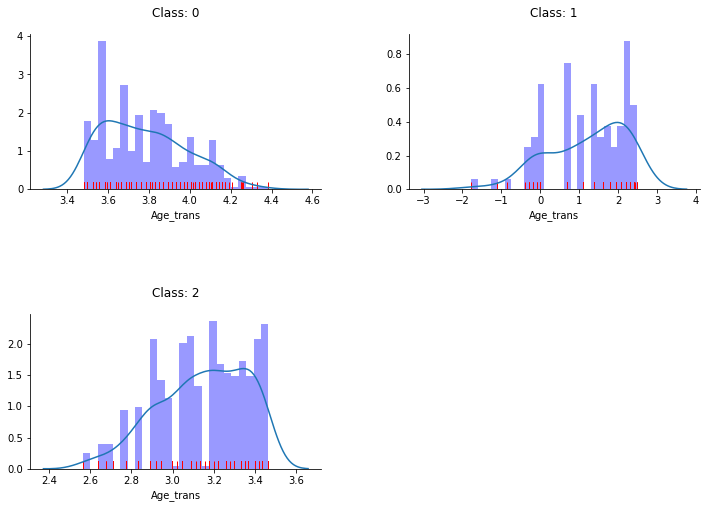

In [225]:
grd = sorted(df_age['Age_cls'].unique())
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 6


fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.8)

for idx, c in enumerate(grd):
    fig.add_subplot(gs[idx])
    df = df_age.loc[df_age['Age_cls']==c, 'Age_trans']
    ax = sns.distplot(df,
                 bins=25, kde=True, norm_hist=True, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Class: {0}'.format(c))

### Distributions within clasters (age - not transformed)

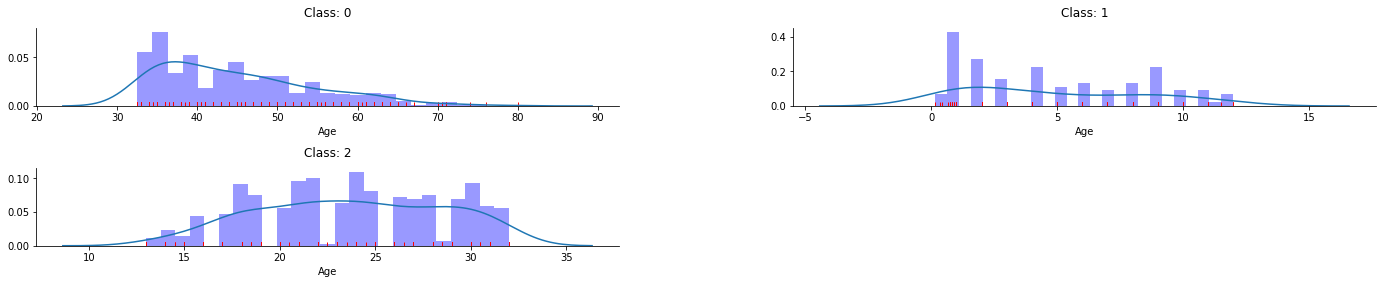

In [71]:
grd = sorted(df_age['Age_cls'].unique())
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 6


fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.8)

for idx, c in enumerate(grd):
    fig.add_subplot(gs[idx])
    df = df_age.loc[df_age['Age_cls']==c, 'Age']
    ax = sns.distplot(df,
                 bins=25, kde=True, norm_hist=True, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Class: {0}'.format(c))

In [72]:
def age_transformer(data, model):
    data['Age'] = data['Age'].apply(np.log)
    X = data['Age'].to_frame()
    data['Age_cls'] = model.predict(X)
    data['Age_cls'] = data['Age_cls'].astype(int)
    return data

### Preprocess data

Use transformer functions defined above.
Also drop Sex as it is highly correlated with ttl. Basicaly the ttl already contains gender information.

In [146]:
data = family_groups_encoder(data_tot.copy(), fgrp_mask)
data = fare_encoder(data, fare_mask)
data = ticket_encoder(data, ticket_mask)
data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)
data = embarked_encoder(data)
data = pclass_encoder(data)

data = data[data['Age'].notna()].copy()
data = age_transformer(data, age_clast_model)

data = data[['Age', 'Age_cls', 'Fare', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked']]
data = pd.get_dummies(data, columns=['ttl', 'Pclass', 'Embarked'])

### Plot correlation matrix:

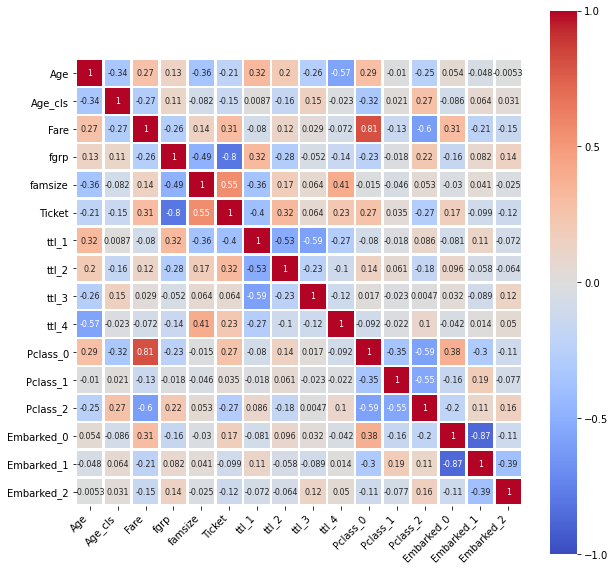

In [107]:
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = data.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1), data=corr_matrix, cmap='coolwarm')

### Train classification model for age class prediction

In [133]:
X = data.drop(columns=['Age', 'Age_cls'])
y = data['Age_cls']

#### Metric functions for multiclass classification

In [77]:
def roc_auc_score_ovr(y_true, y_score):
    return metrics.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None,
                                 multi_class='ovr', labels=None)

def roc_auc_score_ovo(y_true, y_score):
    return metrics.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None,
                                 multi_class='ovo', labels=None)

#### Define cross validation strategy

In [109]:
random_state=30
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)
scoring = {'balanced_accuracy': 'balanced_accuracy',
           'roc_auc_ovr':  metrics.make_scorer(roc_auc_score_ovr, needs_proba=True),
           'roc_auc_ovo':  metrics.make_scorer(roc_auc_score_ovo, needs_proba=True),
           'precision_macro': 'precision_macro'}
refit = 'roc_auc_ovr'

##### Initial model

In [114]:
params = {'learning_rate': 0.1, 
          'n_estimators': 25,
          'min_weight_fraction_leaf': 0.099, 
          'min_impurity_decrease': 0.05,
          'max_depth': 4,
          'subsample': 1.0,
          'ccp_alpha': 0.0}

age_cls_model = ens.GradientBoostingClassifier(loss='deviance', criterion='friedman_mse', 
                                               random_state=random_state, **params)
cv_rep(age_cls_model, X, y, cv, scoring)

,balanced_accuracy,roc_auc_ovr,roc_auc_ovo,precision_macro
mean_train,0.743869,0.862951,0.903441,0.747733
std_train,0.013838,0.006075,0.004483,0.010848
mean_test,0.706854,0.826376,0.877185,0.706078
std_test,0.042856,0.016959,0.014787,0.029135


##### Tune parameters

In [115]:
param_ranges = {'learning_rate': np.linspace(0.001, 2, 40), 'n_estimators': np.arange(5, 100, 20)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy  roc_auc_ovr  roc_auc_ovo  precision_macro
mean_train           0.784003     0.871729     0.922254         0.802312
std_train            0.008738     0.005815     0.003538         0.009796
mean_test            0.731721     0.827037     0.881948         0.739057
std_test             0.021660     0.015277     0.012377         0.022379
{'learning_rate': 0.8211025641025641, 'n_estimators': 5}


In [116]:
param_ranges = {'min_weight_fraction_leaf': np.linspace(0.001, 0.2, 40), 'min_impurity_decrease': np.linspace(0.0001, 0.1, 40)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy  roc_auc_ovr  roc_auc_ovo  precision_macro
mean_train           0.772475     0.869702     0.930477         0.790327
std_train            0.012243     0.006141     0.003292         0.019923
mean_test            0.732645     0.827732     0.881093         0.735938
std_test             0.023862     0.014989     0.012767         0.014681
{'min_impurity_decrease': 0.005223076923076923, 'min_weight_fraction_leaf': 0.11325641025641026}


In [117]:
param_ranges = {'subsample': np.linspace(0.1, 1.0, 50), 'max_depth': np.arange(3, 10)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy  roc_auc_ovr  roc_auc_ovo  precision_macro
mean_train           0.767685     0.869702     0.911581         0.767422
std_train            0.014709     0.006141     0.004395         0.017185
mean_test            0.736763     0.827732     0.880512         0.728696
std_test             0.023178     0.014989     0.015460         0.026185
{'max_depth': 4, 'subsample': 1.0}


In [118]:
param_ranges = {'ccp_alpha': np.linspace(0.00001,0.0001, 99)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy  roc_auc_ovr  roc_auc_ovo  precision_macro
mean_train           0.765663     0.869649     0.910198         0.766038
std_train            0.016636     0.006250     0.005508         0.010258
mean_test            0.724570     0.827784     0.880279         0.719945
std_test             0.024520     0.015087     0.013548         0.021067
{'ccp_alpha': 1e-05}


### Train regression model for age prediction

In [147]:
X = data.drop(columns=['Age'])
X = pd.get_dummies(X, columns=['Age_cls'])
y = data['Age']

#### Define cross validation strategy

In [148]:
random_state=30
cv = model_selection.RepeatedKFold(n_splits=5, n_repeats=10, random_state=random_state)
scoring = {'explained_variance':  'explained_variance', 'r2': 'r2'}
refit='r2'

##### Initial model

In [149]:
params = {'learning_rate': 0.1, 
          'n_estimators': 55,
          'min_weight_fraction_leaf': 0.001, 
          'min_impurity_decrease': 0.5,
          'max_depth': 3,
          'subsample': 1.0,
          'ccp_alpha': 0.001}

age_reg_model = ens.GradientBoostingRegressor(loss='ls', criterion='friedman_mse', random_state=random_state, **params)
cv_rep(age_reg_model, X, y, cv, scoring)

,explained_variance,r2
mean_train,0.855506,0.855506
std_train,0.006636,0.006636
mean_test,0.798998,0.797667
std_test,0.042477,0.042920


##### Tune parameters

In [150]:
param_ranges = {'learning_rate': np.linspace(0.01, 0.1, 40), 'n_estimators': np.arange(5, 100, 25)}
age_reg_model, scores = train_best_model(age_reg_model, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.854007  0.854007
std_train             0.006734  0.006734
mean_test             0.799742  0.798412
std_test              0.041897  0.042332
{'learning_rate': 0.05846153846153847, 'n_estimators': 55}


In [151]:
param_ranges = {'min_weight_fraction_leaf': np.linspace(0.001, 0.2, 40), 'min_impurity_decrease': np.linspace(0.001, 0.5, 40)}
age_reg_model, scores = train_best_model(age_reg_model, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.854007  0.854007
std_train             0.006734  0.006734
mean_test             0.799742  0.798412
std_test              0.041897  0.042332
{'min_impurity_decrease': 0.4744102564102564, 'min_weight_fraction_leaf': 0.001}


In [152]:
param_ranges = {'max_depth': np.arange(2,10), 'subsample': np.linspace(0.1, 1.0, 50)}
age_reg_model, scores = train_best_model(age_reg_model, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.860054  0.860044
std_train             0.006857  0.006857
mean_test             0.802455  0.801155
std_test              0.041774  0.042037
{'max_depth': 3, 'subsample': 0.41224489795918373}


In [153]:
param_ranges = {'ccp_alpha': np.linspace(0.0001, 0.01, 99)}
age_reg_model, scores = train_best_model(age_reg_model, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.859296  0.859286
std_train             0.006925  0.006925
mean_test             0.802464  0.801170
std_test              0.041363  0.041621
{'ccp_alpha': 0.0016153061224489797}


In [155]:
# Age predict (predict missing vakues and log-transform)
def age_predictor(data, age_cls_model, age_reg_model):
    cols = ['Fare', 'fgrp', 'famsize', 'Ticket', 
            'ttl_1', 'ttl_2','ttl_3', 'ttl_4', 
            'Pclass_0', 'Pclass_1', 'Pclass_2', 
            'Embarked_0', 'Embarked_1', 'Embarked_2']

    data_na = data.loc[data['Age'].isnull()].copy()
    data_notna = data.loc[data['Age'].notna()].copy()

    # predict class labels
    X = data_na[cols].copy()
#     X = pd.get_dummies(X, columns=['ttl', 'Pclass', 'Embarked'])
    X['Age_cls'] = age_cls_model.predict(X)

    # predict age
    X = pd.get_dummies(X, columns=['Age_cls'])
    print(X.columns)
    data_na['Age'] = age_reg_model.predict(X)
    return pd.concat([data_na, data_notna])

Index(['Fare', 'fgrp', 'famsize', 'Ticket', 'ttl_1', 'ttl_2', 'ttl_3', 'ttl_4',
       'Pclass_0', 'Pclass_1', 'Pclass_2', 'Embarked_0', 'Embarked_1',
       'Embarked_2', 'Age_cls_0', 'Age_cls_1', 'Age_cls_2'],
      dtype='object')

## Predict survivals

I will use stacking classifier to predict survivals.

Base classifiers for stacking:
* Linear Discriminant Analysis
* Quadratic Discriminant Analysis
* Extra Trees Classifier
* Random Forest Classifier
* Logistic Regression
* Ridge Classifier
* SVC
* nuSVC

For the final classifier in stacking I chose Ada Boost Classifier.

### Preprocessind data

In [156]:
data = family_groups_encoder(data_train.copy(), fgrp_mask)
data = fare_encoder(data, fare_mask)
data = ticket_encoder(data, ticket_mask)
data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)
data = embarked_encoder(data)
data = pclass_encoder(data)

data = data[['PassengerId', 'Survived', 'Age', 'Fare', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked']]
data = pd.get_dummies(data, columns=['ttl', 'Pclass', 'Embarked'])
data = age_predictor(data, age_cls_model, age_reg_model)

Index(['Fare', 'fgrp', 'famsize', 'Ticket', 'ttl_1', 'ttl_2', 'ttl_3', 'ttl_4',
       'Pclass_0', 'Pclass_1', 'Pclass_2', 'Embarked_0', 'Embarked_1',
       'Embarked_2', 'Age_cls_0', 'Age_cls_1', 'Age_cls_2'],
      dtype='object')


### Plot correlation matrix:

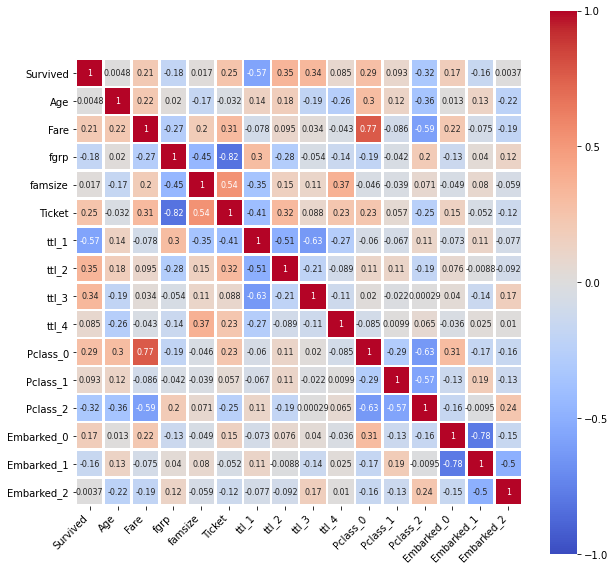

In [157]:
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = data.drop(columns='PassengerId').corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1), data=corr_matrix, cmap='coolwarm')

### Train base estimators for stacking model

In [158]:
X = data.drop(columns=['Survived', 'PassengerId'])
y = data['Survived']

#### Define cross validation strategy

In [159]:
random_state=30
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)
scoring = {'balanced_accuracy': 'balanced_accuracy', 
           'roc_auc':  'roc_auc',
           'precision_macro': 'precision_macro'}
refit = 'roc_auc'

#### Calculate class weights and priors

In [160]:
n = len(y)
class_priors = {}
class_weights = {}
for i in y.unique():
    class_priors[i] = len(y.loc[y==i]) / n
    class_weights[i] = 1- class_priors[i]

In [161]:
# Base estomators scores
base_scores = {}

#### LinearDiscriminantAnalysis

In [162]:
# Initialize
lda = disan.LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

In [205]:
# Tune
param_ranges = {'solver': ['svd', 'lsqr', 'eigen'],}
lda, scores = train_best_model(lda, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.818304  0.872567         0.830353
std_train            0.010123  0.012065         0.008664
mean_test            0.801586  0.860880         0.816270
std_test             0.021881  0.027885         0.021134
{'solver': 'lsqr'}


In [206]:
base_scores['lda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### QuadraticDiscriminantAnalysis

In [165]:
# Initialize
qda = disan.QuadraticDiscriminantAnalysis(priors=[class_priors[0], class_priors[1]], reg_param=0.09)

In [207]:
# Tune
param_ranges = {'reg_param': np.linspace(0.01,0.5,55)}
qda, scores = train_best_model(qda, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.821566  0.887737         0.832871
std_train            0.013759  0.008395         0.009904
mean_test            0.802921  0.869200         0.817799
std_test             0.023669  0.016994         0.028163
{'reg_param': 0.09166666666666666}


/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [208]:
base_scores['qda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### ExtraTreesClassifier

In [168]:
# Initialize
etc = ens.ExtraTreesClassifier(random_state=random_state, 
                               n_jobs=-1, 
                               criterion='entropy',
                               n_estimators=75,
                               max_depth=5,
                               ccp_alpha=0.0)

In [169]:
# Tune
param_ranges = {'criterion': ['gini', 'entropy'], 
                'n_estimators': np.arange(60, 100, 5),
                'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.911797  0.920693         0.850900
std_train            0.009839  0.009068         0.015043
mean_test            0.785322  0.871474         0.831457
std_test             0.018053  0.021378         0.021785
{'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 95}


In [170]:
param_ranges = {'ccp_alpha': np.linspace(0.001,0.01, 60)}
etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.814684  0.913576         0.867701
std_train            0.010595  0.009508         0.006188
mean_test            0.784872  0.872118         0.831650
std_test             0.025954  0.021655         0.022008
{'ccp_alpha': 0.0020677966101694915}


In [171]:
base_scores['etc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### RandomForestClassifier

In [172]:
# Initialize
rfc = ens.RandomForestClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                                 n_estimators=20,
                                 max_depth=5,
                                 ccp_alpha=0.04)

In [173]:
param_ranges = {'criterion': ['gini', 'entropy'], 
                'n_estimators': np.arange(5, 100, 10),
                'max_depth': np.arange(3, 10)}
rfc, scores = train_best_model(rfc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.809608  0.869776         0.834213
std_train            0.013400  0.013147         0.019609
mean_test            0.783866  0.862536         0.823277
std_test             0.029032  0.020653         0.036723
{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 85}


In [174]:
# Tune
param_ranges = {'ccp_alpha': np.linspace(0.001,0.1, 60)}
rfc, scores = train_best_model(rfc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.859342  0.929456         0.849357
std_train            0.015600  0.009061         0.014726
mean_test            0.799688  0.873989         0.848941
std_test             0.024001  0.019816         0.028014
{'ccp_alpha': 0.009389830508474577}


In [175]:
base_scores['rfc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### LogisticRegression

In [176]:
# Initialize
lr = lm.LogisticRegression(class_weight=class_weights, 
                           random_state=random_state, 
                           n_jobs=-1,
                           penalty='l2',
                           solver='liblinear',
                           dual=False,
                           C=1.3)

In [177]:
# Tune
param_ranges = {'C': np.linspace(0.01, 5, 99), 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
lr, scores = train_best_model(lr, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.819354  0.874555         0.814789
std_train            0.012784  0.011645         0.012116
mean_test            0.799250  0.866399         0.797918
std_test             0.023801  0.024105         0.022282
{'C': 0.2136734693877551, 'solver': 'liblinear'}


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [178]:
base_scores['lr'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### RidgeClassifier

In [179]:
# Initialize
rc = lm.RidgeClassifier(class_weight=class_weights, random_state=random_state,
                        alpha=11.12)

In [180]:
# Tune
param_ranges = {'alpha': np.linspace(1, 45, 99)}
rc, scores = train_best_model(rc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.810671  0.872698         0.812605
std_train            0.011050  0.012155         0.011492
mean_test            0.798023  0.864381         0.802908
std_test             0.021778  0.023432         0.019637
{'alpha': 36.91836734693877}


In [181]:
base_scores['rc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### SVC

In [182]:
# Initialize
svc = svm.SVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weights,
              C=2000)

In [183]:
# Tune
param_ranges = {'C': np.linspace(1000, 3000, 55)}
svc, scores = train_best_model(svc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.809380  0.868961         0.819473
std_train            0.012470  0.010208         0.012304
mean_test            0.795107  0.852395         0.803836
std_test             0.025640  0.020558         0.019036
{'C': 2037.037037037037}


In [184]:
base_scores['svc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

In [185]:
# Initialize
nusvc = svm.NuSVC(kernel='rbf', 
                  gamma='scale', 
                  shrinking=True, 
                  class_weight=class_weights,
                  nu=0.51)

In [186]:
# Tune
param_ranges = {'nu': np.linspace(0.1,1.0,99)}
nusvc, scores = train_best_model(nusvc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.803722  0.857259         0.822608
std_train            0.010337  0.014088         0.010324
mean_test            0.788779  0.836867         0.809869
std_test             0.025946  0.020068         0.023150
{'nu': 0.6602040816326531}


In [187]:
base_scores['nusvc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

### Base estimators scores

In [188]:
pd.DataFrame(base_scores, index=['test_score', 'train_score']).sort_values(by='test_score', axis=1,ascending=False)

,rfc,etc,qda,lr,rc,lda,svc,nusvc
test_score,0.873989,0.872118,0.869270,0.866399,0.864381,0.860880,0.852395,0.836867
train_score,0.929456,0.913576,0.887557,0.874555,0.872698,0.872567,0.868961,0.857259


In [190]:
base_models_surv_dic = {'lda':lda,'qda':qda,'etc':etc,'rfc':rfc,'lr':lr,'rc':rc,'svc':svc,'nusvc':nusvc}

In [191]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

### Confusion matrices

/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


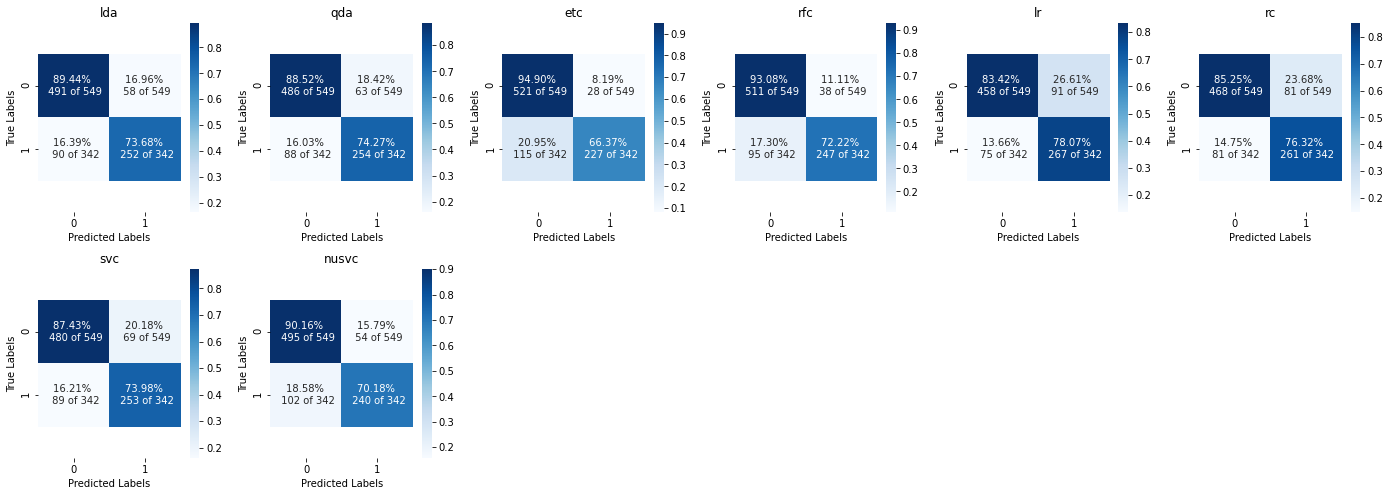

In [192]:
grd_n = len(base_models_surv)
grd_cols_n = 6
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(4 * grd_cols_n, 4 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(base_models_surv):
    lbl, model = m
    plot_confusion_matrix(model, X, y, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

### Base estimators correlation matrix

In [193]:
def base_models_predictions(models, X):
    X1 = None
    for i, model in models:
        if X1 is None:
            X1 = pd.Series(model.predict(X), name=i).to_frame()
        else:
            X1 = X1.merge(pd.Series(model.predict(X), name=i).to_frame(), left_index=True, right_index=True)
    return X1

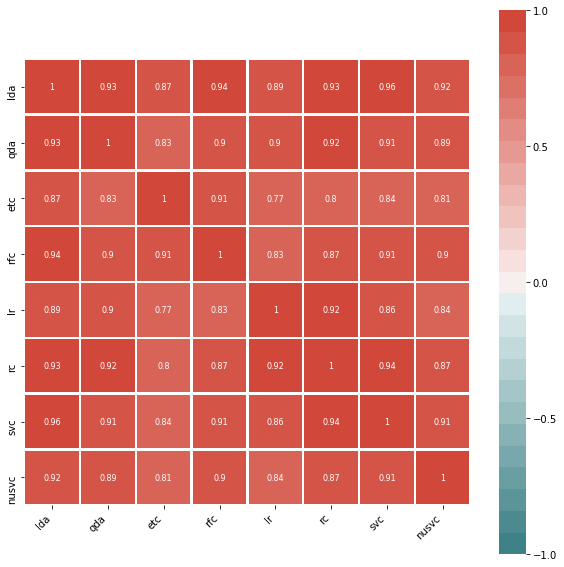

In [194]:
preds_base = base_models_predictions(base_models_surv, X)
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = preds_base.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap=sns.diverging_palette(200, 15, s=75, l=50, sep=1, n=25, center='light', as_cmap=False))

In [195]:
# Mean of each model correlation coefficients
corr_sc = {}
for k in base_models_surv_dic.keys():
    corr_sc[k] = (corr_matrix[k].sum() - 1) / len(corr_matrix.index)
df_base_models_corr_sc = pd.DataFrame(corr_sc, index=['cc'])
df_base_models_corr_sc.sort_values(by='cc', axis=1, ascending=False)

,lda,svc,qda,rc,rfc,nusvc,lr,etc
cc,0.803521,0.790198,0.785777,0.78097,0.780824,0.765906,0.751391,0.728686


### Select less correlated models

In [209]:
base_models_surv_dic = {'lda':lda,'etc':etc,'lr':lr,'rc':rc,'svc':svc}

In [210]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

### Train stacking classifier

In [211]:
# Initialize
model_st = ens.StackingClassifier(estimators=base_models_surv,
                                  final_estimator=ens.AdaBoostClassifier(random_state=random_state),
                                  cv=5, 
                                  stack_method='predict', 
                                  passthrough=False,
                                  n_jobs=-1)

cv_rep(model_st, X, y, cv, scoring)

,balanced_accuracy,roc_auc,precision_macro
mean_train,0.820805,0.854874,0.842778
std_train,0.008782,0.012840,0.015375
mean_test,0.795207,0.821906,0.818829
std_test,0.020722,0.029159,0.023984


In [212]:
# Tune
param_ranges = {'final_estimator__n_estimators': np.arange(50, 120, 10), 'final_estimator__learning_rate': np.linspace(0.1, 0.8, 20)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.821293  0.854050         0.843110
std_train            0.009138  0.013042         0.015400
mean_test            0.795207  0.823719         0.818829
std_test             0.020722  0.028203         0.023984
{'final_estimator__learning_rate': 0.28421052631578947, 'final_estimator__n_estimators': 60}


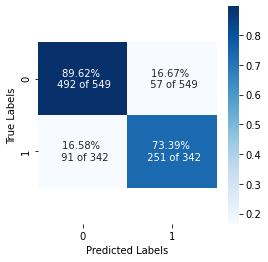

In [213]:
fig = plt.figure()
fig.set_size_inches(4,4)
plot_confusion_matrix(model_st, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')

## Predict test set
### Preprocessind data

In [214]:
data = family_groups_encoder(data_test.copy(), fgrp_mask)
data = fare_encoder(data, fare_mask)
data = ticket_encoder(data, ticket_mask)
data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)
data = embarked_encoder(data)
data = pclass_encoder(data)

data = data[['PassengerId', 'Age', 'Fare', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked']]
data = pd.get_dummies(data, columns=['ttl', 'Pclass', 'Embarked'])
data = age_predictor(data, age_cls_model, age_reg_model)

Index(['Fare', 'fgrp', 'famsize', 'Ticket', 'ttl_1', 'ttl_2', 'ttl_3', 'ttl_4',
       'Pclass_0', 'Pclass_1', 'Pclass_2', 'Embarked_0', 'Embarked_1',
       'Embarked_2', 'Age_cls_0', 'Age_cls_1', 'Age_cls_2'],
      dtype='object')


### Make predictions

In [215]:
X = data.drop(columns=['PassengerId'])

In [216]:
data['Survived'] = model_st.predict(X)
df_submission = data[['PassengerId', 'Survived']]
df_submission.to_csv("submission.csv", index=False)